<a href="https://colab.research.google.com/github/hritikac25/fentanyl_overdose_covid/blob/main/Overdose_Trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files


uploaded = files.upload()

Saving overdoses-latest.csv to overdoses-latest.csv


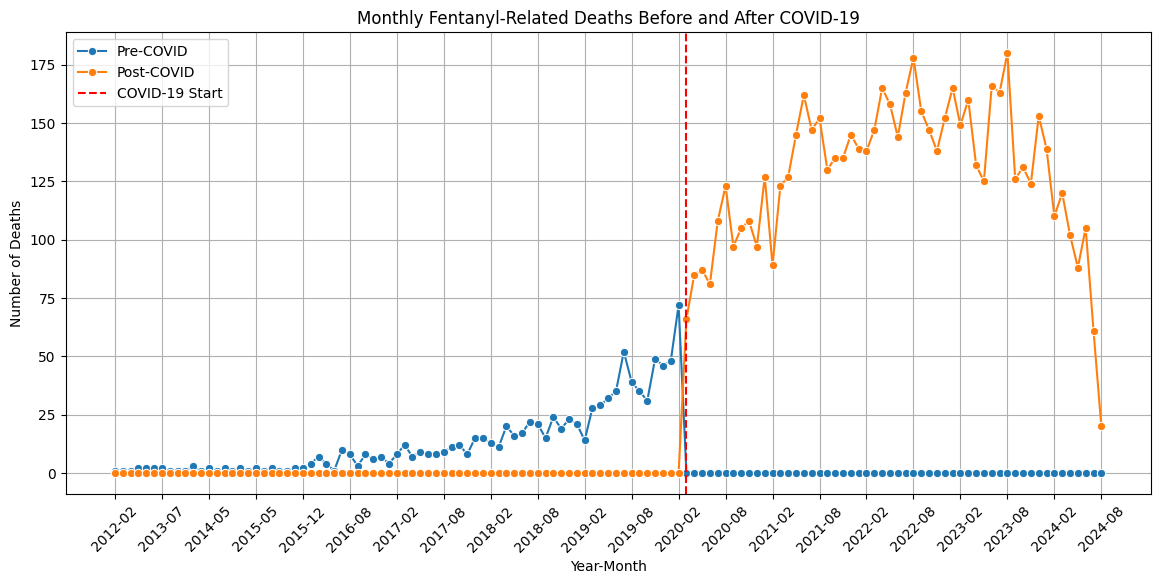

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset with low_memory=False to prevent dtype warnings
df = pd.read_csv("overdoses-latest.csv", low_memory=False)

# Convert DeathDate to datetime format
df["DeathDate"] = pd.to_datetime(df["DeathDate"], errors="coerce")

# Create a binary column for pre- and post-COVID deaths
covid_cutoff = pd.to_datetime("2020-03-01")
df["Post_COVID"] = df["DeathDate"] >= covid_cutoff

# Filter only fentanyl-related deaths and create a copy to avoid warnings
df_fentanyl = df[df["Fentanyl"] == 1].copy()

# Convert to Year-Month format for time-series analysis
df_fentanyl["YearMonth"] = df_fentanyl["DeathDate"].dt.to_period("M").astype(str)

# Aggregate counts with zero fill to prevent missing data issues
monthly_counts = df_fentanyl.groupby("YearMonth")["Post_COVID"].value_counts().unstack(fill_value=0)

# Reset index for plotting
monthly_counts = monthly_counts.reset_index()

# Plot time-series
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_counts, x="YearMonth", y=False, label="Pre-COVID", marker="o")
sns.lineplot(data=monthly_counts, x="YearMonth", y=True, label="Post-COVID", marker="o")

# Mark COVID cutoff
plt.axvline(x="2020-03", color="red", linestyle="--", label="COVID-19 Start")

# Improve X-axis readability
plt.xticks(ticks=monthly_counts["YearMonth"][::6], rotation=45)  # Show every 6th month

# Formatting
plt.title("Monthly Fentanyl-Related Deaths Before and After COVID-19")
plt.xlabel("Year-Month")
plt.ylabel("Number of Deaths")
plt.legend()
plt.grid(True)

# Show plot
plt.show()



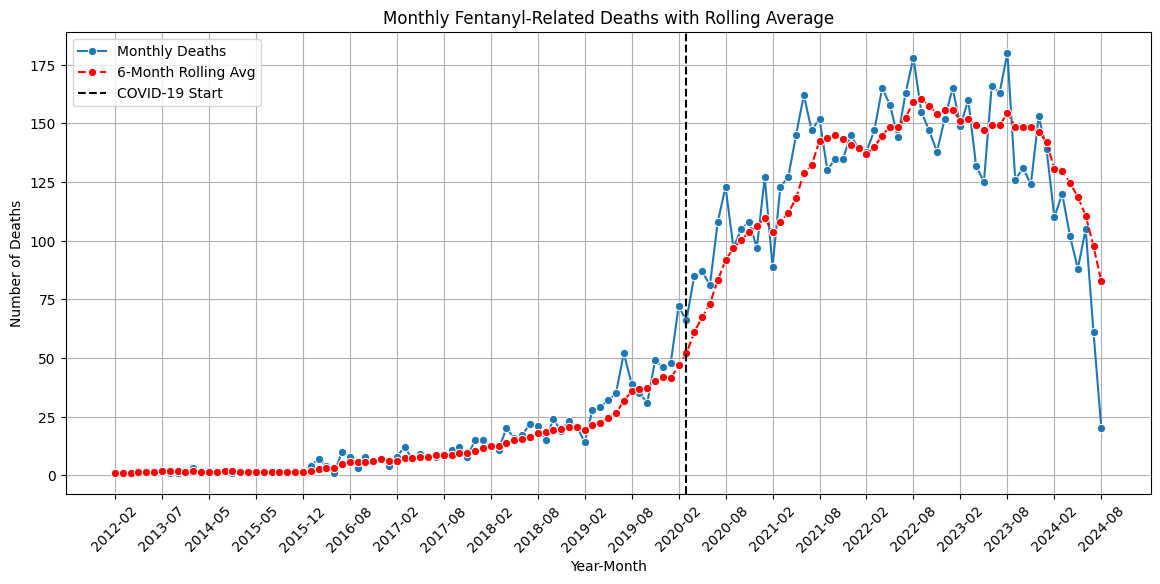

In [8]:
#Enhanced Graph

# Load dataset with low_memory=False to prevent dtype warnings
df = pd.read_csv("overdoses-latest.csv", low_memory=False)

# Convert DeathDate to datetime format
df["DeathDate"] = pd.to_datetime(df["DeathDate"], errors="coerce")

# Filter fentanyl-related deaths
df_fentanyl = df[df["Fentanyl"] == 1].copy()

# Define pre- and post-COVID periods
covid_cutoff = pd.to_datetime("2020-03-01")
df_fentanyl["Post_COVID"] = df_fentanyl["DeathDate"] >= covid_cutoff

# Convert to Year-Month format for analysis
df_fentanyl["YearMonth"] = df_fentanyl["DeathDate"].dt.to_period("M")

# Aggregate counts for visualization
monthly_counts = df_fentanyl.groupby("YearMonth")["Post_COVID"].value_counts().unstack(fill_value=0)

# Calculate percentage change
pre_covid_avg = monthly_counts.loc[: "2020-02"].mean()
post_covid_avg = monthly_counts.loc["2020-03":].mean()
percent_change = ((post_covid_avg - pre_covid_avg) / pre_covid_avg) * 100

# Rolling average for trend smoothing
monthly_counts["Total"] = monthly_counts.sum(axis=1)
monthly_counts["Rolling_Avg"] = monthly_counts["Total"].rolling(window=6, min_periods=1).mean()

# Plot time-series with rolling average
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_counts, x=monthly_counts.index.astype(str), y="Total", label="Monthly Deaths", marker="o")
sns.lineplot(data=monthly_counts, x=monthly_counts.index.astype(str), y="Rolling_Avg", label="6-Month Rolling Avg", marker="o", linestyle="dashed", color="red")

# Mark COVID cutoff
plt.axvline(x="2020-03", color="black", linestyle="--", label="COVID-19 Start")

# Formatting
plt.xticks(ticks=monthly_counts.index.astype(str)[::6], rotation=45)  # Show every 6th month
plt.title("Monthly Fentanyl-Related Deaths with Rolling Average")
plt.xlabel("Year-Month")
plt.ylabel("Number of Deaths")
plt.legend()
plt.grid(True)

# Show plot
plt.show()




<ipython-input-11-9ae010521fd1>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_counts = df_fentanyl.groupby(["AgeGroup", "Post_COVID"]).size().unstack(fill_value=0)


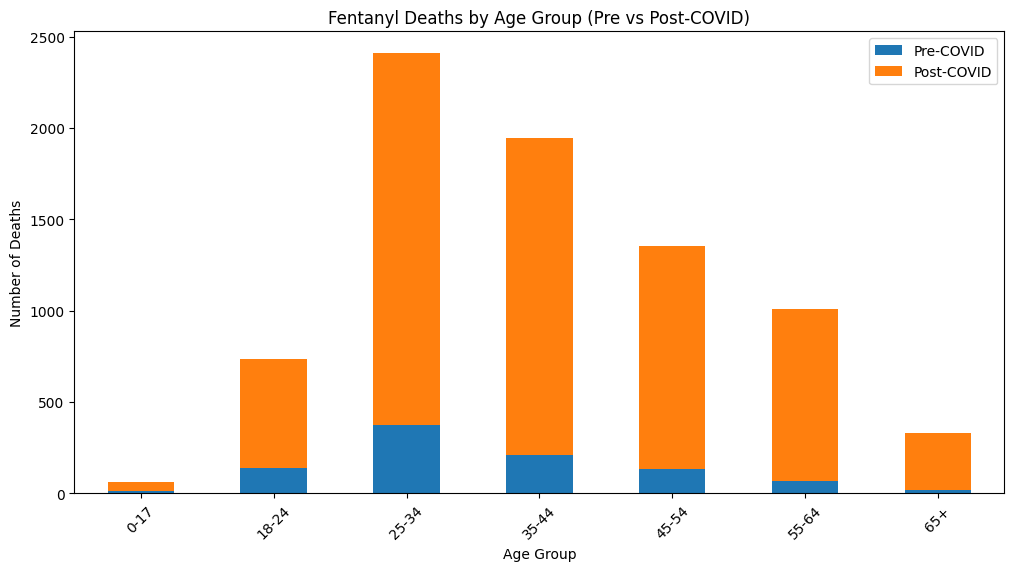

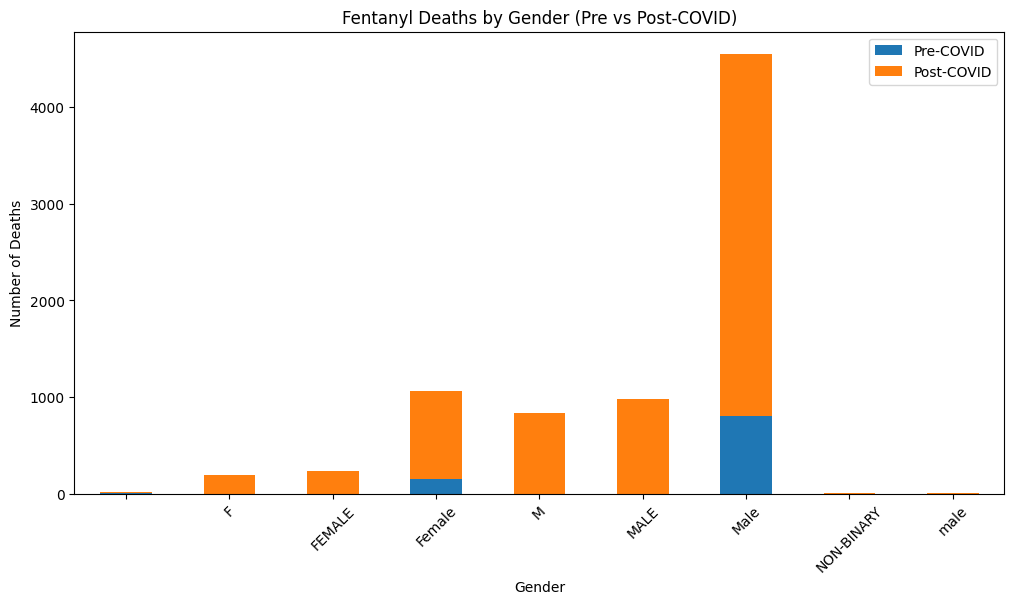

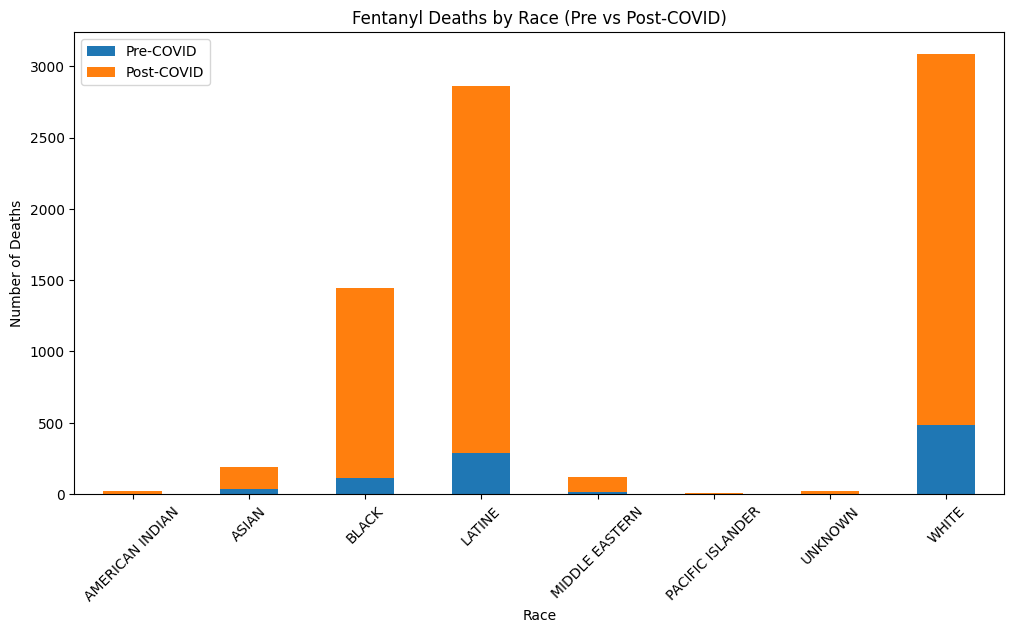

In [11]:
#Demographic breakdown
# Define age bins and labels
age_bins = [0, 17, 24, 34, 44, 54, 64, float("inf")]
age_labels = ["0-17", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

# Create AgeGroup column
df_fentanyl["AgeGroup"] = pd.cut(df_fentanyl["Age"], bins=age_bins, labels=age_labels, right=False)

# Aggregate demographic data
age_counts = df_fentanyl.groupby(["AgeGroup", "Post_COVID"]).size().unstack(fill_value=0)
gender_counts = df_fentanyl.groupby(["Gender", "Post_COVID"]).size().unstack(fill_value=0)
race_counts = df_fentanyl.groupby(["Race", "Post_COVID"]).size().unstack(fill_value=0)

# Set unified figure size and style
figsize = (12, 6)

# Plot age distribution
age_counts.plot(kind="bar", stacked=True, figsize=figsize, title="Fentanyl Deaths by Age Group (Pre vs Post-COVID)")
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.xticks(rotation=45)
plt.legend(["Pre-COVID", "Post-COVID"])
plt.show()

# Plot gender distribution
gender_counts.plot(kind="bar", stacked=True, figsize=figsize, title="Fentanyl Deaths by Gender (Pre vs Post-COVID)")
plt.xlabel("Gender")
plt.ylabel("Number of Deaths")
plt.xticks(rotation=45)
plt.legend(["Pre-COVID", "Post-COVID"])
plt.show()

# Plot race distribution
race_counts.plot(kind="bar", stacked=True, figsize=figsize, title="Fentanyl Deaths by Race (Pre vs Post-COVID)")
plt.xlabel("Race")
plt.ylabel("Number of Deaths")
plt.xticks(rotation=45)
plt.legend(["Pre-COVID", "Post-COVID"])
plt.show()


In [14]:
#Heat Map
import folium
from folium.plugins import MarkerCluster

# Drop rows with missing lat/lon values
df_map = df_fentanyl.dropna(subset=["lat", "lon"])

# Create map centered on LA
map_center = [34.0522, -118.2437]  # Default to LA
m = folium.Map(location=map_center, zoom_start=10)

# Add marker clusters
marker_cluster = MarkerCluster().add_to(m)

# Add points to the map
for _, row in df_map.iterrows():
    folium.Marker(
        location=[row["lat"], row["lon"]],
        popup=f"Date: {row['DeathDate']}<br>Age: {row['Age']}<br>Gender: {row['Gender']}<br>Race: {row['Race']}",
    ).add_to(marker_cluster)

# Save map to an HTML file
m.save("fentanyl_deaths_map.html")


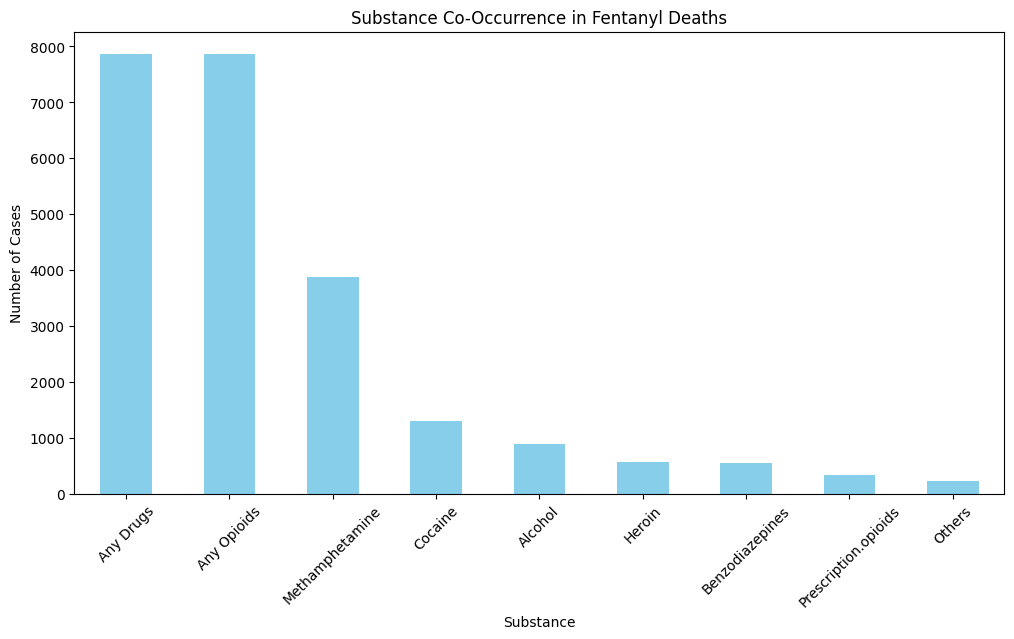

In [20]:
#Co-occurence chart

# Corrected substance column list
substance_cols = [
    "Methamphetamine",
    "Heroin",
    "Cocaine",
    "Alcohol",
    "Prescription.opioids",
    "Any Opioids",
    "Benzodiazepines",
    "Others",
    "Any Drugs"
]

# Count co-occurrence of substances with fentanyl
substance_counts = df_fentanyl[substance_cols].sum().sort_values(ascending=False)

# Plot co-occurrence
substance_counts.plot(kind="bar", figsize=(12, 6), title="Substance Co-Occurrence in Fentanyl Deaths", color="skyblue")
plt.xlabel("Substance")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.show()
